In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import math
import random
import joblib

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Lambda
from sklearn import preprocessing
import math as mm
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [0]:
def KLMGRV(t, P, ags): #Система уравнений Колмогорова
    n, m, lam, mu, tog = ags
    nu = 1 / tog
    diffp = [-lam * P[0] + mu * P[1]]
    for i in range(1, n):
        diffp.append(lam * P[i - 1] - (lam + i * mu) * P[i] + (i + 1) * mu * P[i + 1])
    for i in range(n, n + m):
        diffp.append(lam * P[i - 1] - (lam + n * mu + (i - n) * nu) * P[i] + (n * mu + (i - n + 1) * nu) * P[i + 1])
    diffp.append(lam * P[n + m - 1] - (n * mu + m * nu) * P[n + m])
    return np.array(diffp) 

In [0]:
def RKF(f, T0, P0, T, tau, ags): #метод Рунге-Кутта_Фельберга
    def next_app(f, t, P, tau): #высчитываем коэффициенты для решения в следующий момент времени
        k1 = tau * f(t, P, ags)
        k2 = tau * f(t + (1 / 4) * tau, P + (1 / 4) * k1 * tau, ags)
        k3 = tau * f(t + (3 / 8) * tau, P + (3 / 32) * k1 * tau + (9 / 32) * k2 * tau, ags)
        k4 = tau * f(t + (12 / 13) * tau, P + (1932 / 2197) * k1 * tau - (7200 / 2197) * k2 * tau + (7296 / 2197) * k3 * tau, ags)
        k5 = tau * f(t + tau, P + (439 / 216) * k1 * tau - 8 * k2 * tau + (3680 / 513) * k3 * tau - (845 / 4104) * k4 * tau, ags)
        k6 = tau * f(t + (1 / 2) * tau,
                     P - (8 / 27) * k1 * tau + 2 * k2 * tau - (3544 / 2565) * k3 * tau + (1859 / 4104) * k4 * tau - (11 / 40) * k5 * tau, ags)
        return (16 / 135) * k1 + (6656 / 12825) * k3 + (28561 / 56430) * k4 - (9 / 50) * k5 + (2 / 55) * k6
    t = list()
    t.append(T0)
    P = list()
    P.append(P0)
    while T0 < T: #находим решения для каждого момента времени
        tau = min(tau, T - T0)
        P0 = P0 + next_app(f, T0, P0, tau)
        T0 = T0 + tau
        t.append(T0)
        P.append(P0)
    return np.array(t), np.array(P)

In [0]:
n = 2 #число каналов в СМО
m = 3 #число мест в очереди
lam = 0.5 #интенсивность поступления в СМО заявок
mu = 0.05 #интенсивность обслуживания заявок
tog = 15 #среднее время ожидания заявки в очереди
nu = 1 / tog #интенсивность потока ухода заявок из очереди
ro = lam / mu #коэффициент загрузки СМО

T0 = 0 #начальный момент времени
T = 40 #конечный момент времени
tau = 0.1 #шаг
P0 = np.zeros(n + m + 1) #значения вероятностей наличия заявок в начальный момент времени
P0[0] = 1 #вероятность отсутствия заявок в начальный момент времени

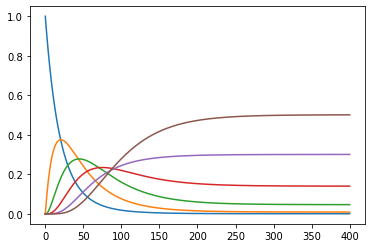

In [0]:
ags = [2,3,0.5,0.05,15]
t, P = RKF(KLMGRV, T0, P0, T, tau, ags)
plt.plot(P)

In [0]:
def props(ags):
  n, m, lam, mu, tog = ags
  nu = 1 / tog #интенсивность потока ухода заявок из очереди
  ro = lam / mu #коэффициент загрузки СМО
  pokazateli = list()

  #Для этого сначала найдем предельные вероятности:
  p = list()
  sum_first = np.sum(np.array([ro**i / mm.factorial(i) for i in range(n + 1)]))
  def mult(z): #функция для перемножения
      multy = 1
      for i in range(1, z + 1):
          beta = nu / mu
          multy *= n + i * beta
      return multy
  sum_second = np.sum(np.array([ro**(n + i) / mm.factorial(n) / mult(i) for i in range(1, m + 1)]))
  p0 = 1 / (sum_first + sum_second) #предельная вероятность отсутсвия заявок
  p.append(p0)
  for i in range(1, n + 1):
      p.append(p0 * ro**i / mm.factorial(i)) #предельные вероятности для [1; n] заявок
  for i in range(1, m + 1):
      p.append(p0 * ro**(n + i) / mult(i) / mm.factorial(n)) #предельные вероятности для [n + 1; n + m] заявок

  p_ots = (np.sum(np.array(p[: n])), 'Вероятность отсутствия очереди p_ots')
  pokazateli.append(p_ots)

  p_och = (np.sum(np.array(p[n: n + m + 1])), 'Вероятность образования очереди p_och')
  pokazateli.append(p_och)

  p_otk = (p[n + m], 'Вероятность отказа в обслуживании p_otk')
  pokazateli.append(p_otk)

  Q = (1 - p_otk[0], 'Относительная пропускная способность Q')
  pokazateli.append(Q) #т.е. вероятность обслуживания поступившей в СМО заявки

  A = (lam * Q[0], 'Абсолютная пропусная способность A')
  pokazateli.append(A) #т.е. среднее число заявок, обслуживаемых в СМО в единицу времени

  L_och = (np.sum([i * p[n + i] for i in range(1, m + 1)]), 'Среднее число заявок, находящихся в очереди L_och')
  pokazateli.append(L_och)

  L_obs = (np.sum([i * p[i] for i in range(1, n + 1)]) + np.sum([n * p[n + i] for i in range(1, m + 1)]), 'Среднее число заявок, обслуживаемых в СМО L_obs')
  pokazateli.append(L_obs)

  L_smo = (L_och[0] + L_obs[0], 'Среднее число заявок, находящихся в СМО L_smo')
  pokazateli.append(L_smo)

  T_och = (tog, 'Среднее время ожидания заявки в очереди T_och')
  pokazateli.append(T_och)

  T_obs = (Q[0] / mu, 'Среднее время обслуживания T_obs')
  pokazateli.append(T_obs)

  T_smo = (T_och[0] + T_obs[0], 'Среднее время пребывания заявки в СМО T_smo')
  pokazateli.append(T_smo)

  return pokazateli

In [0]:
pokazateli = props(ags)

In [0]:
X, Y = [], []
for m in range(1, 5):
  for tog in [1,5,10, 15, 20]:
    for lam in np.arange(0.05,1,0.1):
      for mu in np.arange(0.05,1.5,0.1):

        n= 5-m
        nu = 1 / tog
        ro = lam / mu 

        T0 = 0 
        T = 40 
        tau = 0.2 
        P0 = np.zeros(n + m + 1) 
        P0[0] = 1 
        ags = [n,m,lam,mu,tog]
        t, P = RKF(KLMGRV, T0, P0, T, tau, ags)

        X_train = np.vstack([t,np.full(len(t), m), np.full(len(t), n), np.full(len(t), tog), np.full(len(t), lam), np.full(len(t), mu)]).T

        Y_train = P
        X.extend(X_train)
        Y.extend(Y_train)

In [0]:
X, Y = [], []
for m in range(1, 5):
  for tog in [1,5,10, 15, 20]:
    for lam in np.arange(0.05,1,0.1):
      for mu in np.arange(0.05,1.5,0.1):

        n= 5-m
        nu = 1 / tog
        ro = lam / mu 

        T0 = 0
        T = 40
        tau = 0.2
        P0 = np.zeros(n + m + 1)
        P0[0] = 1
        ags = [n,m,lam,mu,tog]

        t, P = RKF(KLMGRV, T0, P0, T, tau, ags)

        X_train = np.array(ags)
        Y_train = np.array([item[0] for item in props(ags)])
        X.append(X_train)
        Y.append(Y_train)

In [0]:
scaler = preprocessing.MinMaxScaler()
Y = scaler.fit_transform(Y)

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=5, min_lr=0.0001, verbose = 1)
e_s = EarlyStopping(monitor = 'loss', patience = 6)
act = 'sigmoid'
def model(inp_shape):
    inp = Input(shape = (inp_shape,))
    x1 = Dense(512, activation = 'sigmoid')(inp)
    x1 = Dense(512, activation = 'sigmoid')(x1)
    out = Dense(len(pokazateli), activation = act)(x1)
    model = Model(inputs = inp, outputs = out)
    model.compile(optimizer = 'adam', loss = 'mae')
    return model
mod2 = model(np.array(X).shape[1])

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=0.000001, verbose = 1)
e_s = EarlyStopping(monitor = 'loss', patience = 3)
act = 'sigmoid'
def model(inp_shape):
    inp = Input(shape = (inp_shape,))
    x1 = Dense(1024, activation = 'relu')(inp)
    x1 = Dense(1024, activation = 'relu')(x1)
    x1 = Dense(512, activation = 'sigmoid')(x1)
    out = Dense(n+m+1, activation = 'sigmoid')(x1)
    model = Model(inputs = inp, outputs = out)
    model.compile(optimizer = 'adam', loss = 'mae')
    return model
mod = model(X.shape[1])

In [0]:
X = np.array(X)
Y = np.array(Y)

In [0]:
hist = mod.fit(X, Y, epochs = 20 
               , batch_size= 1000,  callbacks=[reduce_lr])

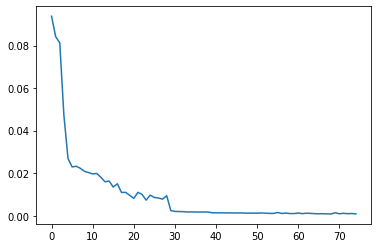

In [0]:
plt.plot(hist.history['loss'])

In [0]:
hist = mod2.fit(X, Y, epochs = 100 
               , batch_size= 100,  callbacks=[reduce_lr, e_s])

In [0]:
import joblib
mod = joblib.load('/content/SMO_weights_final2.sav')
mod2 = joblib.load('/content/SMO_weights_final2props.sav')


n, m, lam, mu, tog:  3 2 0.7255418596643255 1.3149127737757036 14
Показатели СМО:
Вероятность отсутствия очереди p_ots  =  0.9974729308153716  /  0.9952102 diff:  0.002262760069521974
Вероятность образования очереди p_och  =  0.0025270691846284725  /  0.0048006484 diff:  0.002273579243871226
Вероятность отказа в обслуживании p_otk  =  0.0003027256148969586  /  0.00043908934 diff:  0.0001363637296846305
Относительная пропускная способность Q  =  0.999697274385103  /  0.9995278 diff:  0.00016946238101367417
Абсолютная пропусная способность A  =  0.7253222195587251  /  0.72597504 diff:  0.000652817062368638
Среднее число заявок, находящихся в очереди L_och  =  0.0003027256148969586  /  0.0018787093 diff:  0.0015759836845928971
Среднее число заявок, обслуживаемых в СМО L_obs  =  0.5515959771368372  /  0.54040366 diff:  0.011192313024746103
Среднее число заявок, находящихся в СМО L_smo  =  0.5518987027517341  /  0.5475745 diff:  0.004324182640650154
Среднее время ожидания заявки в очереди T

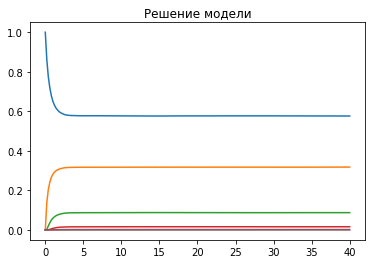

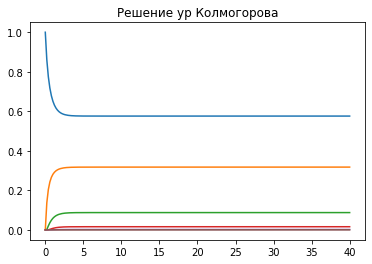

In [80]:
%%time
m = random.randint(1,3)
n = 5- m
lam = random.uniform(0.001,1)  
mu = random.uniform(0.001,1.5)
tog = random.randint(1,20)  
ags = [n,m,lam,mu,tog]
t, P = RKF(KLMGRV, T0, P0, T, tau, ags)
pokazateli = np.array(props(ags))
# n, m, lam, mu, tog = ags
print('n, m, lam, mu, tog: ', n-1, m+1, lam, mu, tog)
X_test= np.vstack([t,np.full(len(t), m), np.full(len(t), n), np.full(len(t), tog), np.full(len(t), lam), np.full(len(t), mu)]).T
res = mod.predict(X_test)

X_test2 = np.array([ags])

res_prop = scaler.inverse_transform(mod2.predict(X_test2))

print('Показатели СМО:')
i=0
for item in pokazateli:
    print(item[1],' = ', item[0],' / ', res_prop[0][i], 'diff: ', abs(float(item[0]) - res_prop[0][i]))
    i+=1

plt.figure()
plt.title('Решение модели')
plt.plot(t,res[:,:n+m+1])
plt.figure()
plt.title('Решение ур Колмогорова')
plt.plot(t,P)
print('Погрешности для конечных вероятностей: ',abs(res[-1:,:n+m+1] - P[-1]))

интенсивность 0.38364425
вероятность отсутсвия очереди 0.2731865
вероятность образования очереди 0.7268135
вероятность отказа 0.2478585303963242
относительная пропускная способность 0.7521414696036758
абсолютная пропускная способность 0.28855475
среднее число заявок в очереди 1.629516
среднее количество заявок на обслуживании 1.771637
среднее число заявок в системе 3.401153
среднее время ожидания в очереди 3.9905919067352036
среднее время обслуживания 11.232052228543305
среднее время пребывания заявки в СМО 21.14992834498632
вероятность ухода из очереди 0.527059899894238
предельная вероятность  0   0.00097
предельная вероятность  1   0.00906
предельная вероятность  2   0.04512
предельная вероятность  2 - 0   0.04512
предельная вероятность  2 - 1   0.13596
предельная вероятность  2 - 2   0.2828
предельная вероятность  2 - 3   0.52609


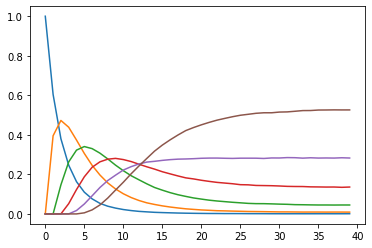

CPU times: user 19.6 s, sys: 3.91 ms, total: 19.6 s
Wall time: 19.6 s


In [41]:
%%time
import random
import math
import matplotlib
from matplotlib import pylab
import numpy as np

class Requests(object):
    def __init__(self, lmbd, wait_average, doing_time):
        self.arrive_time = math.ceil(math.log(random.random())/(-lmbd))
        #self.arrive_time = math.ceil(np.random.exponential(1 / lmbd))
        #self.arrive_time = math.ceil(random.expovariate(lmbd))
        self.leave_time = math.ceil(random.expovariate(1/wait_average))
        #self.leave_time = math.ceil(np.random.exponential(wait_average))
        #self.leave_time = math.ceil(math.log(random.random()) / (-wait_average))
        self.doing_time = math.ceil(random.expovariate(doing_time))
        #self.doing_time = math.ceil(np.random.exponential(doing_time))
        #self.doing_time = math.ceil(math.log(random.random()) / (-doing_time))
        #self.arrive_time = int(1/lmbd)
        #self.leave_time = wait_average
        #self.doing_time = int(1/doing_time)

    time_of_living = 0
    time_of_doing = 0

    def living(self):
        self.time_of_living += 1

    def doing(self):
        self.time_of_doing += 1

    def get_arrive(self):
        return self.arrive_time

    def get_doing(self):
        return self.doing_time

    def get_leaving(self):
        return self.leave_time

    def get_living(self):
        return self.time_of_living


n, m, end_time = 2, 3, 40
lmbd, wait_average, doing_time = 0.5, 15, 0.05
trying_requests, completed_requests, denied_requests = 0, 0, 0
time_in_system, time_in_queue, time_in_channel = 0, 0, 0
requests_in_queue, request_in_channels, requests_in_system = 0, 0, 0
queues = 0
iterations = 100000
probabilities = [[0 for i in range(n + m + 2)] for j in range(end_time)]
for i in range(iterations):
    queue = []
    channels = [None for j in range(n)]
    new_request = Requests(lmbd, wait_average, doing_time)
    time_to_next_left = int(new_request.get_arrive())
    for current_time in range(end_time):
        # из очереди в канал
        if len(queue) != 0:
            if None in channels:
                time_in_queue += queue[0].time_of_living
                channels[channels.index(None)] = queue[0]
                queue.pop(0)
        # новый заказ
        if time_to_next_left == 0:
            new_request = Requests(lmbd, wait_average, doing_time)
            trying_requests += 1
            # если есть свободный канал, то на него
            if None in channels:
                channels[channels.index(None)] = new_request
            # иначе в очередь
            elif len(queue) < m:
                queue.append(new_request)
            # или вообще отказ
            else:
                denied_requests += 1
                probabilities[current_time][-1] += 1
            time_to_next_left = int(new_request.get_arrive())
        time_to_next_left -= 1
        # обновляем заявки в каналах
        doing = 0
        for item in channels:
            if item is not None:
                item.living()
                item.doing()
                doing += 1
                if item.time_of_doing == item.get_doing():
                    channels[channels.index(item)] = None
                    completed_requests += 1
                    time_in_system += item.time_of_living
                    time_in_channel += item.time_of_doing
        # записываем, была ли очередь и сколько где заявок
        if len(queue) > 0:
            queues += 1
        requests_in_queue += len(queue)
        request_in_channels += doing
        requests_in_system += len(queue) + doing
        probabilities[current_time][len(queue) + doing] += 1
        # обновляем заявки в очереди
        for item in queue:
            item.living()
            if item.get_living() == item.get_leaving():
                queue.remove(item)
                time_in_system += item.time_of_living
                time_in_queue += item.time_of_living

print('интенсивность', trying_requests/(iterations*end_time))
print('вероятность отсутсвия очереди', (end_time*iterations - queues)/(end_time*iterations))
print('вероятность образования очереди', queues/(end_time*iterations))
print('вероятность отказа', denied_requests/trying_requests)
print('относительная пропускная способность', (trying_requests - denied_requests)/trying_requests)
print('абсолютная пропускная способность', (trying_requests - denied_requests)/(end_time*iterations))
print('среднее число заявок в очереди', requests_in_queue/(end_time*iterations))
print('среднее количество заявок на обслуживании', request_in_channels/(end_time*iterations))
print('среднее число заявок в системе', requests_in_system/(end_time*iterations))
print('среднее время ожидания в очереди', time_in_queue/(trying_requests - denied_requests))
print('среднее время обслуживания', time_in_channel/completed_requests)
print('среднее время пребывания заявки в СМО', time_in_system/completed_requests)
print('вероятность ухода из очереди', (trying_requests - denied_requests - completed_requests)/trying_requests)
for i in range(n + 1):
    print('предельная вероятность ', i, ' ', probabilities[-1][i]/iterations)
for i in range(m + 1):
    print('предельная вероятность ', n, '-', i, ' ', probabilities[-1][i + n] / iterations)
# print('предельная вероятность отказа', probabilities[-1][-1]/iterations)

x = [i for i in range(len(probabilities))]
for j in range(len(probabilities[0])-1):
    plot = [0 for i in range(len(probabilities))]
    for i in range(len(probabilities)):
        plot[i] = probabilities[i][j]/iterations
    pylab.plot(x, plot)
pylab.show()



Показатели СМО:
Вероятность отсутствия очереди p_ots  =  0.04724964162333238  /  0.06695283 diff:  0.019703190419838548
Вероятность образования очереди p_och  =  0.9527503583766675  /  0.92956483 diff:  0.023185524735615304
Вероятность отказа в обслуживании p_otk  =  0.5257359426971189  /  0.5314867 diff:  0.005750747347284202
Относительная пропускная способность Q  =  0.4742640573028811  /  0.4756795 diff:  0.0014154296870938499
Абсолютная пропусная способность A  =  0.23713202865144056  /  0.23437007 diff:  0.0027619609357957264
Среднее число заявок, находящихся в очереди L_och  =  1.3493889195892717  /  1.2652242 diff:  0.08416470122074138
Среднее число заявок, обслуживаемых в СМО L_obs  =  2.9434553469097824  /  3.023728 diff:  0.08027254691956331
Среднее число заявок, находящихся в СМО L_smo  =  4.2928442664990545  /  4.231621 diff:  0.061223477924835734
Среднее время ожидания заявки в очереди T_och  =  15  /  14.964777 diff:  0.03522300720214844
Среднее время обслуживания T_obs  

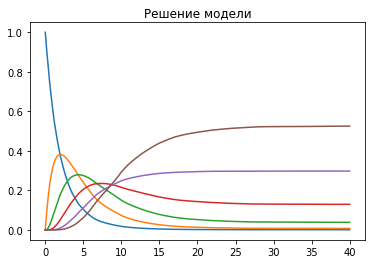

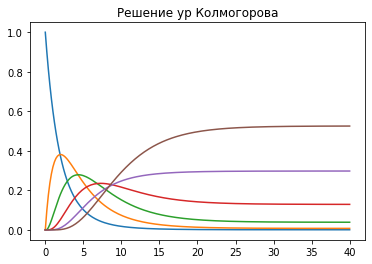

In [58]:
ags = [3,2,0.5,0.05,15]
t, P = RKF(KLMGRV, T0, P0, T, tau, ags)
pokazateli = np.array(props(ags))
n, m, lam, mu, tog = ags
nu = 1 / tog
ro = lam / mu 
X_test= np.vstack([t,np.full(len(t), m), np.full(len(t), n), np.full(len(t), tog), np.full(len(t), lam), np.full(len(t), mu)]).T
res = mod.predict(X_test)

X_test2 = np.array([ags])

res_prop = scaler.inverse_transform(mod2.predict(X_test2))

print('Показатели СМО:')
i=0
for item in pokazateli:
    print(item[1],' = ', item[0],' / ', res_prop[0][i], 'diff: ', abs(float(item[0]) - res_prop[0][i]))
    i+=1
plt.figure()
plt.title('Решение модели')
plt.plot(t,res[:,:n+m+1])
plt.figure()
plt.title('Решение ур Колмогорова')
plt.plot(t,P)
print(abs(res[-1:,:n+m+1] - P[-1]))